# Machine Learning COS-623 - Terceiro Trimestre de 2017
## Terceira e Quarta Listas de Exercı́cios (Graduação e Pós-Graduação)



In [35]:
# Importando bibliotecas úteis
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn

In [31]:
## Lendo o dataset e separando os dados em 1000 dados de treino e 172 dados de teste
df = pd.read_csv("Dados-medicos.txt",sep=" ")
df = df.drop('Unnamed: 1', 1)
df = df.drop('Unnamed: 2', 1)

train = df.sample(frac = 0.85324232082,random_state=200)
test  = df.drop(train.index)
list(test)

['IDADE', 'Peso', 'Carga_Final', 'VO2_medido_máximo']

### Questão 1


      features         w
0  Carga_Final  0.133087


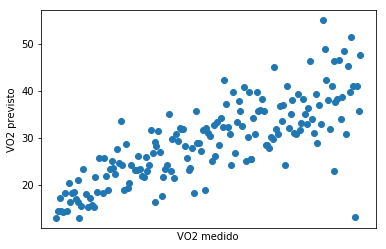

O RMSE foi de 5.248248
O NLL foi de -571.207806


In [95]:
from sklearn.linear_model import LinearRegression

data = train[['Carga_Final','VO2_medido_máximo']]
X = data.drop('VO2_medido_máximo', axis = 1)

lm = LinearRegression()
lm.fit(X,data.VO2_medido_máximo)
print(pd.DataFrame(list(zip(X.columns,lm.coef_)),columns = ['features','w']))

plt.scatter(test[['VO2_medido_máximo']],lm.predict(test[['Carga_Final']]))
plt.xlabel("VO2 medido")
plt.ylabel("VO2 previsto")
plt.xticks(np.arange(50, 0, 10))
plt.show();

rmse =  np.sqrt(np.mean( (test.VO2_medido_máximo - lm.predict(test[['Carga_Final']]) ) **2 ))

print("O RMSE foi de %f" % (rmse)) 

var = test[['VO2_medido_máximo']].var()
nll = -(len(test)/2)*np.log(2*np.pi*var) - (1/(2*var))* np.sum( (test.VO2_medido_máximo - lm.predict(test[['Carga_Final']]) ) **2 )
print("O NLL foi de %f" % (nll)) 